# CARGA DE LIBRERIAS

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

import torch
from torch import nn  # Modelos neuronales y funciones de Loss

from torch import optim # (3er paso BACKPROPAGATION) Optimizadores ---> Gradiente descendiente, Adam, AdaDelta, etc
from torch.utils.data import Dataset, DataLoader

import sys

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Elige el dispositivo. Utilizará GPU si está disponible

sys.path.append('/home/sebacastillo/neuralnets/')
from src.utils import get_project_root
root = get_project_root()

In [31]:
dir = str(root) + '/course_bib/Ejercicio2_resuelto/'

In [32]:
data = pd.read_csv( dir + 'irisbin.csv', header=None).to_numpy()

# RBF NN

In [33]:
class RBFNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_centers, sigma):
        super(RBFNet, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_centers = num_centers
        
        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))
        self.beta = nn.Parameter(torch.ones(num_centers, 1) / num_centers)
        self.sigma = sigma
        
        self.fc = nn.Linear(num_centers, output_dim)
    
    def radial_basis(self, x):
        C = self.centers.view(self.num_centers, -1)
        x = x.unsqueeze(1).expand(-1, self.num_centers, -1)
        return torch.exp(-torch.sum((x - C) ** 2, dim=2) / (2 * self.sigma ** 2))
    
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        H = self.radial_basis(x)
        out = self.fc(H)
        return out

In [34]:
class DATASET(Dataset):  # <----------------
    '''
    Esta clase maneja la lectura de los datos y provee un mecanismo
    para alimentar los modelos con los patrones.
    '''
    
    #===================================================
    def __init__(self, filename):
        
        #------------------------------------
        # LECTURA DE LOS DATOS
        data = pd.read_csv(filename, header=0) # Levanta los datos en formato numpy
        
        #------------------------------------
        # TRANSFORMO A DATOS DE NUMPY
        data = data.to_numpy()
        
        #------------------------------------
        # ALEATORIZO LOS PATRONES (filas)
        idxs = np.arange(len(data))  # Genero un vector de índices
        np.random.shuffle(idxs)
        data = data[idxs,:]
        
        #------------------------------------
        # SEPARO LOS DATOS
        self.x = data[:,:-1].astype(np.float32)
        self.y = data[:,-1].astype(np.longlong)  # La clase está en la última columna
        
    
    #===================================================
    def __len__(self):
        '''
        Devuelve el número de patrones en el dataset.
        '''
        return len(self.x)
    
    
    #===================================================
    def __getitem__(self, idx):
        '''
        Devuelve el/los patrones indicados.
        '''
        return self.x[idx,:], self.y[idx]

In [35]:
BATCH_SIZE=32
filename_train = dir + 'data_trn.csv'
filename_test = dir + 'data_tst.csv'

trn = DATASET(filename_train)
tst = DATASET(filename_test)

train_loader = DataLoader(trn, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(tst, batch_size=BATCH_SIZE, shuffle=False)

In [36]:
# dataloaders
input_dim = 4
hidden_dim = 10
output_dim = 3
num_centers = 10
sigma = 1.0
model = RBFNet(input_dim, hidden_dim, output_dim, num_centers, sigma)

# loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# epochs
epochs = 140

# Evaluation objects
train_losses = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    correct = 0.0
    model.train() 
    for inputs, labels in train_loader:
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item() * inputs.size(0)
        
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            # calculate accuracy
            _, pred = torch.max(outputs, dim=1)
            correct += pred.eq(labels).sum().item()    
   
    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    # append losses and accuracy
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)

    if (epoch % 20) == 0:
        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f} \tTest Loss: {test_loss:.6f} \tTest Accuracy: {accuracy:.6f}')


Epoch: 1 	Training Loss: 1.093893 	Test Loss: 1.101463 	Test Accuracy: 0.275862
Epoch: 21 	Training Loss: 1.082967 	Test Loss: 1.117461 	Test Accuracy: 0.379310
Epoch: 41 	Training Loss: 1.052465 	Test Loss: 1.066401 	Test Accuracy: 0.379310
Epoch: 61 	Training Loss: 0.642933 	Test Loss: 0.695805 	Test Accuracy: 0.655172
Epoch: 81 	Training Loss: 0.489803 	Test Loss: 0.534382 	Test Accuracy: 0.655172
Epoch: 101 	Training Loss: 0.456384 	Test Loss: 0.498294 	Test Accuracy: 0.655172
Epoch: 121 	Training Loss: 0.346369 	Test Loss: 0.345677 	Test Accuracy: 1.000000


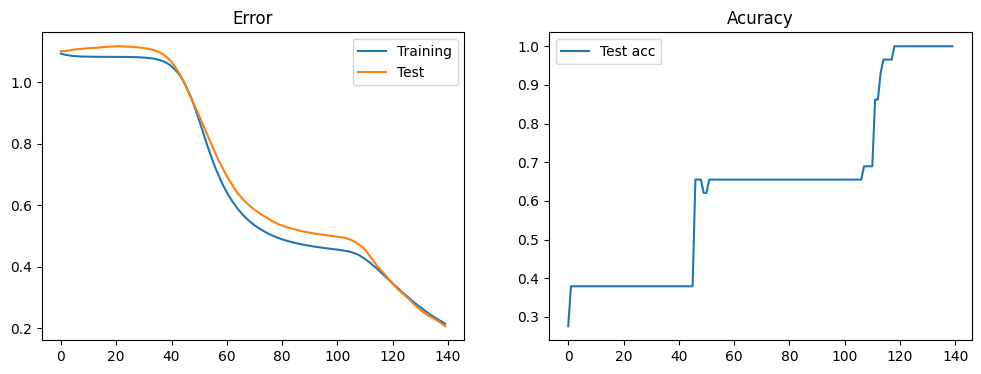

In [37]:
# plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training')
plt.plot(test_losses, label='Test')
plt.legend()
plt.title('Error')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test acc')
plt.legend()
plt.title('Acuracy')

plt.show()